# Monte Carlo simulation of danish student loans

Import libraries

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Download neccesarry data

In [6]:
# Define the stock ticker and the time period
ticker = 'VYM'
start_date = '2007-01-01'
end_date = '2024-10-28'  # You can set it to today's date or any desired end date

# Download the stock price data
data = yf.download(ticker, start=start_date, end=end_date, interval='1d')

# Download the dividend data
stock = yf.Ticker(ticker)
dividends = stock.dividends.loc[start_date:end_date]

# Display the first few rows of price data
print(data.head())

# Display the first few rows of dividend data
print(dividends.head())

data.to_csv('/Users/sorenlund/Desktop/VYM_stock_data.csv')
dividends.to_csv('/Users/sorenlund/Desktop/VYM_dividends_data.csv')


[*********************100%%**********************]  1 of 1 completed

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2007-01-03  51.959999  52.090000  51.470001  51.720001  29.787029   35000
2007-01-04  51.400002  51.700001  51.389999  51.590000  29.712170   11400
2007-01-05  51.500000  51.500000  51.160000  51.230000  29.504826   10500
2007-01-08  51.189999  51.290001  51.000000  51.240002  29.510593   21800
2007-01-09  51.240002  51.290001  51.029999  51.200001  29.487553   34400
Date
2007-03-26 00:00:00-04:00    0.268
2007-06-25 00:00:00-04:00    0.296
2007-09-24 00:00:00-04:00    0.346
2007-12-14 00:00:00-05:00    0.447
2008-03-25 00:00:00-04:00    0.371
Name: Dividends, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [4]:
data = pd.read_csv('/Users/sorenlund/Desktop/VYM_stock_data.csv')
dividends = pd.read_csv('/Users/sorenlund/Desktop/VYM_dividends_data.csv')

### Calculate Daily Returns

We are calculating the daily returns to capture the day-to-day flucations in the ETF's price which is usefull for understand the short-term volatillity. 

<Axes: >

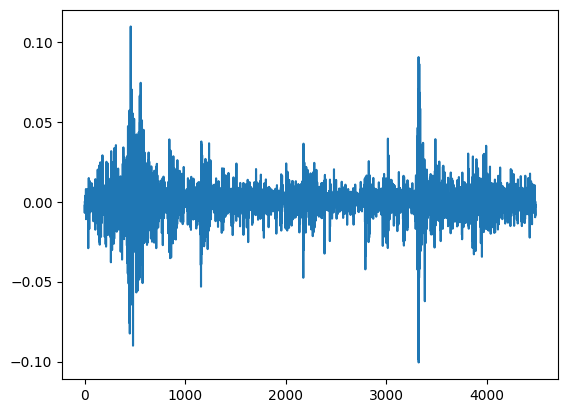

In [5]:
# Calculate daily returns
data['daily_returns'] = data['Adj Close'].pct_change()

# Drop NaN values caused by the shift
data = data.dropna()

data['daily_returns'].plot()


### Calculate total turn 

We are calculating the total return including the dividends. The purpose of this is to adjust the daily reutnrs to account for the dividends. By adding the ratio of dividends to the adjusted closing price, it approximates the effect of reinvesting dividends, providing a more accurate measure of total returns. This is critical for the simulation as it reflects a more realistic scenario of investment growth. 

In [9]:
#dividends.index = dividends.index.tz_localize(None)


# Merge the dividends with the stock price data based on date
data = data.merge(dividends, left_index=True, right_index=True, how='left')

# Fill missing dividends with 0 (no dividend for those days)
data['Dividends'] = data['Dividends'].fillna(0)

# Calculate daily return with dividends reinvested (approximation)
data['total_return'] = data['daily_returns'] + (data['Dividends'] / data['Adj Close'])

data['total_return']


1       0.007449
2       0.004748
3       0.015343
4       0.011801
5       0.011424
          ...   
4480   -0.009739
4481    0.000154
4482   -0.003457
4483   -0.001850
4484   -0.008109
Name: total_return, Length: 4484, dtype: float64

<Axes: >

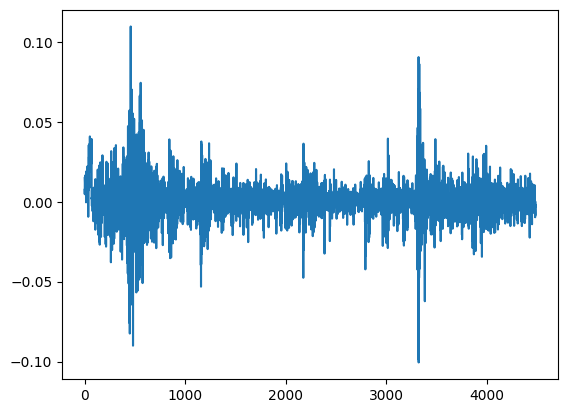

In [10]:
data['total_return'].plot()

In [13]:
print("The mean return of the data is:", data['total_return'].mean())
print("The variance of the data is:", data['total_return'].var())

The mean return of the data is: 0.0006848069677446421
The variance of the data is: 0.00014236824294373347


/var/folders/65/1n30j6qx5qg79xwsb8vr4v1c0000gn/T/ipykernel_3463/3907353561.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M').apply({


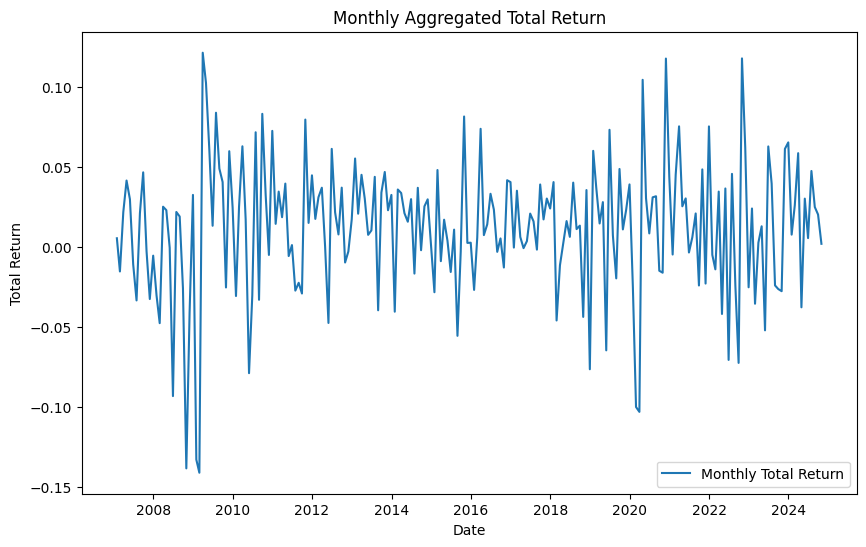

In [34]:
# Ensure the index is in datetime format if not already
data.index = pd.to_datetime(data.index)

# Calculate the monthly aggregate of total returns
monthly_data = data.resample('M').apply({
    'total_return': 'sum',  
    'daily_returns': 'sum', 
})

plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index, monthly_data['total_return'], label='Monthly Total Return')
plt.xlabel('Date')
plt.ylabel('Total Return')
plt.title('Monthly Aggregated Total Return')
plt.legend()
plt.show()


/var/folders/65/1n30j6qx5qg79xwsb8vr4v1c0000gn/T/ipykernel_3463/4086662311.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = data.resample('Y').apply({


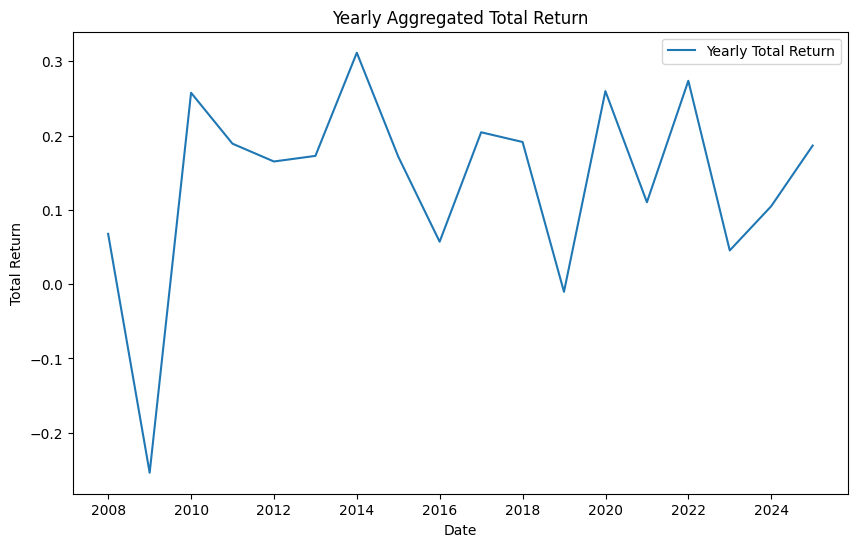

In [32]:
# Calculate the monthly aggregate of total returns
yearly_data = data.resample('Y').apply({
    'total_return': 'sum', 
    'daily_returns': 'sum',  
})

plt.figure(figsize=(10, 6))
plt.plot(yearly_data.index, yearly_data['total_return'], label='Yearly Total Return')
plt.xlabel('Date')
plt.ylabel('Total Return')
plt.title('Yearly Aggregated Total Return')
plt.legend()
plt.show()


## Monte Carlo simulation code

In [33]:
# Parameters
n_simulations = 50000
n_months = 36
monthly_investment = 500 # I can barrow 3500 which is approx. 500 USD
annual_interest_rate = 0.04
monthly_interest_rate = (1 + annual_interest_rate)**(1/12) - 1

# Prepare a list to store the final portfolio values
final_portfolio_values = []

# Perform Monte Carlo simulation
for sim in range(n_simulations):
    portfolio_value = 0
    loan_balance = 0
    for month in range(n_months):
        # Sample a random monthly return from historical daily returns
        daily_returns_sample = np.random.choice(data['total_return'], size=21)  # Approx. 21 trading days per month
        monthly_return = np.prod(1 + daily_returns_sample) - 1  # Compound daily returns to get the monthly return, include 1+ for the growth factor

        # Add monthly investment
        loan_balance += monthly_investment
        portfolio_value += monthly_investment
        
        # Update portfolio with the monthly return
        portfolio_value *= (1 + monthly_return)

        # Accumulate loan interest
        loan_balance *= (1 + monthly_interest_rate)
    
    # Subtract the loan balance at the end of the period
    net_value = portfolio_value - loan_balance
    final_portfolio_values.append(net_value)

# Convert to numpy array for easier analysis
final_portfolio_values = np.array(final_portfolio_values)

# Summary statistics
mean_value = np.mean(final_portfolio_values)
median_value = np.median(final_portfolio_values)
std_value = np.std(final_portfolio_values)
percentiles = np.percentile(final_portfolio_values, [5, 25, 50, 75, 95])

print(f"Mean Final Portfolio Value: {mean_value}")
print(f"Median Final Portfolio Value: {median_value}")
print(f"Standard Deviation: {std_value}")
print(f"5th Percentile: {percentiles[0]}")
print(f"25th Percentile: {percentiles[1]}")
print(f"50th Percentile: {percentiles[2]}")
print(f"75th Percentile: {percentiles[3]}")
print(f"95th Percentile: {percentiles[4]}")


Mean Final Portfolio Value: 3392.440189771862
Median Final Portfolio Value: 2883.336990610631
Standard Deviation: 4581.4000649670525
5th Percentile: -3173.094261081209
25th Percentile: 148.50058035917027
50th Percentile: 2883.336990610631
75th Percentile: 6074.739886319616
95th Percentile: 11641.170662523184


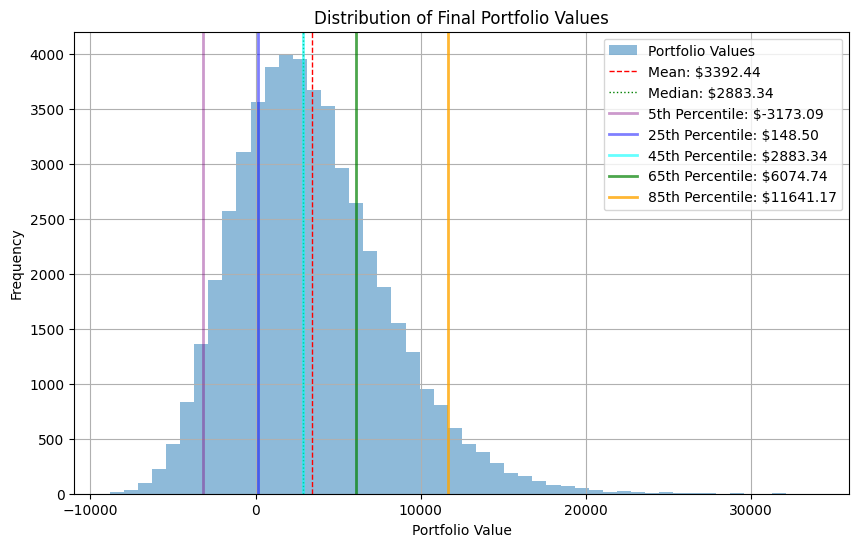

In [40]:
# Create histogram for visualization using only the selected percentiles
plt.figure(figsize=(10, 6))
plt.hist(final_portfolio_values, bins=50, alpha=0.5, label='Portfolio Values')
plt.axvline(mean_value, color='r', linestyle='dashed', linewidth=1, label=f'Mean: ${mean_value:.2f}')
plt.axvline(median_value, color='g', linestyle='dotted', linewidth=1, label=f'Median: ${median_value:.2f}')

# Highlighting the selected percentiles with varying alpha values
percentile_values = np.percentile(final_portfolio_values, [5, 25, 50, 75, 95])
colors = ['purple', 'blue', 'cyan', 'green', 'orange']
alphas = [0.4, 0.5, 0.6, 0.7, 0.8]
for percentile, color, alpha in zip(percentile_values, colors, alphas):
    plt.axvline(percentile, color=color, linestyle='solid', linewidth=2, alpha=alpha, 
                 label=f'{(np.where(percentile_values == percentile)[0][0]*20 + 5)}th Percentile: ${percentile:.2f}')

plt.title('Distribution of Final Portfolio Values')
plt.xlabel('Portfolio Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()



From this we can see that in approxmiately 75% of the outcomes the profitabililty after 4 years we will have made money. However, I thought this does not represent how I would manage it. 

Instead I came up with a new idea. I wanted to make an analysis where I invest for the student loan for four years and then start paying off the loan by paying the minimum amount. This of course leads to a new assignment about enginnering the optimal amount of money to service the debt to find the sweet spot between saving on taxes because of debt and not paying to much interest, since that also combines. However, for simplificity i decided just to use the minimum amount of payment.

Monthly payment from: https://su.dk/su-laan/naar-du-skal-betale-laan-tilbage (The information is written in danish)

In [ ]:
# Parameters
n_simulations = 50000
initial_investment_months = 36
debt_servicing_months = 156  # 13 years of debt servicing
monthly_investment = 500
monthly_debt_payment = 170
annual_interest_rate = 0.04
monthly_interest_rate = (1 + annual_interest_rate)**(1/12) - 1
monthly_interest_rate_post_study = (1 + 0.041)**(1/12) - 1

# Prepare a list to store the final portfolio values
final_portfolio_values = []

# Perform Monte Carlo simulation
for sim in range(n_simulations):
    # Phase 1: Monthly investment for 36 months
    portfolio_value = 0
    loan_balance = 0
    for month in range(initial_investment_months):
        # Sample a random monthly return from historical daily returns
        daily_returns_sample = np.random.choice(data['total_return'], size=21)  # Approx. 21 trading days per month
        monthly_return = np.prod(1 + daily_returns_sample) - 1  # Compound daily returns to get the monthly return

        # Add monthly investment
        loan_balance += monthly_investment
        portfolio_value += monthly_investment
        
        # Update portfolio with the monthly return
        portfolio_value *= (1 + monthly_return)

        # Accumulate loan interest
        loan_balance *= (1 + monthly_interest_rate)

    # Phase 2: Debt repayment phase for 13 years (156 months) without further investment
    for month in range(debt_servicing_months):
        # Sample a random monthly return from historical daily returns
        daily_returns_sample = np.random.choice(data['total_return'], size=21)
        monthly_return = np.prod(1 + daily_returns_sample) - 1

        # Apply monthly return to portfolio
        portfolio_value *= (1 + monthly_return)
        
        # Pay off the loan
        loan_balance -= monthly_debt_payment
        loan_balance *= (1 + monthly_interest_rate_post_study)  
        
        # Ensure loan balance doesn't go negative
        if loan_balance < 0:
            loan_balance = 0

    # Calculate net portfolio value after debt servicing period
    net_value = portfolio_value - loan_balance
    final_portfolio_values.append(net_value)

# Convert to numpy array for easier analysis
final_portfolio_values = np.array(final_portfolio_values)

In [33]:
# Summary statistics
mean_value = np.mean(final_portfolio_values)
median_value = np.median(final_portfolio_values)
std_value = np.std(final_portfolio_values)
percentiles = np.percentile(final_portfolio_values, [0,1,5, 25, 50, 75, 95])

print(f"Mean Final Portfolio Value: {mean_value}")
print(f"Median Final Portfolio Value: {median_value}")
print(f"Standard Deviation: {std_value}")
print(f"0th Percentile: {percentiles[0]}")
print(f"1th Percentile: {percentiles[1]}")
print(f"5th Percentile: {percentiles[2]}")
print(f"25th Percentile: {percentiles[3]}")
print(f"50th Percentile: {percentiles[4]}")
print(f"75th Percentile: {percentiles[5]}")
print(f"95th Percentile: {percentiles[6]}")

Mean Final Portfolio Value: 223228.38077890716
Median Final Portfolio Value: 172761.78532664553
Standard Deviation: 184322.6345373507
0th Percentile: 6034.285155567191
1th Percentile: 33019.24233431402
5th Percentile: 53605.32927956649
25th Percentile: 107253.55784618155
50th Percentile: 172761.78532664553
75th Percentile: 279140.22561773064
95th Percentile: 556053.4859994672


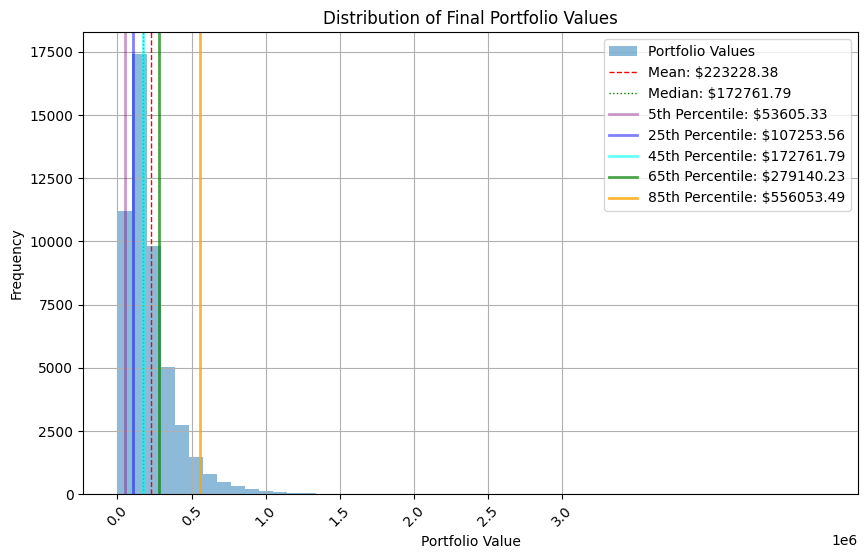

In [29]:
plt.figure(figsize=(10, 6))
plt.hist(final_portfolio_values, bins=50, alpha=0.5, label='Portfolio Values')
plt.axvline(mean_value, color='r', linestyle='dashed', linewidth=1, label=f'Mean: ${mean_value:.2f}')
plt.axvline(median_value, color='g', linestyle='dotted', linewidth=1, label=f'Median: ${median_value:.2f}')

# Highlighting the selected percentiles with varying alpha values
percentile_values = np.percentile(final_portfolio_values, [5, 25, 50, 75, 95])
colors = ['purple', 'blue', 'cyan', 'green', 'orange']
alphas = [0.4, 0.5, 0.6, 0.7, 0.8]
for percentile, color, alpha in zip(percentile_values, colors, alphas):
    plt.axvline(percentile, color=color, linestyle='solid', linewidth=2, alpha=alpha,
                 label=f'{(np.where(percentile_values == percentile)[0][0]*20 + 5)}th Percentile: ${percentile:.2f}')

# Setting x-ticks with increments of 500,000 up to 3,000,000
plt.xticks(np.arange(0, 3_500_000, 500_000))
plt.xticks(rotation=45)

# Labels, title, legend, and grid
plt.title('Distribution of Final Portfolio Values')
plt.xlabel('Portfolio Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Calculate the debt after 36 months
n_months = 36
monthly_investment = 500
annual_interest_rate = 0.04
monthly_interest_rate = (1 + annual_interest_rate)**(1/12) - 1

# Initialize loan balance
loan_balance = 0

# Calculate loan balance after 36 months
for month in range(n_months):
    # Add monthly investment to loan balance
    loan_balance += monthly_investment
    # Apply monthly interest
    loan_balance *= (1 + monthly_interest_rate)

loan_balance

19132.97643956646

# Interpretting the results

As we can see there is actually not a single scenerio after $36+ 156 = 192$ months that yields in a negative portfolio. We get a median return of 172761$ which means half the the portfilio is worth more than 172761 while the 5th percentile gives us a porfit of 53605$, while not being a big profit, we would still be profitable.  

So with a mean outcome of 223,228 USD, it does appear that, on average, borrowing money to invest yields a substantial final portfolio value. The positive median and skewed distribution suggest that the strategy will most likely produce favorable outcomes. 